In [3]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import datetime 
import gmaps
import sys
sys.path.insert(1, '/ignore/api_key')
from api_key import api_key
from pylab import *

In [4]:
#Load in csv 
df = pd.read_csv("analyze_me.csv")

In [312]:
#Check for non-null counts, clearly there are many null values in the item_name, item_quantity, and item_catgeory_name columns. 
#Dtypes for the timestamps are incorrect, need to be reformatted to datetime objects. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5983 entries, 0 to 5982
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   delivery_id                          5983 non-null   int64  
 1   customer_id                          5983 non-null   int64  
 2   jumpman_id                           5983 non-null   int64  
 3   vehicle_type                         5983 non-null   object 
 4   pickup_place                         5983 non-null   object 
 5   place_category                       5100 non-null   object 
 6   item_name                            4753 non-null   object 
 7   item_quantity                        4753 non-null   float64
 8   item_category_name                   4753 non-null   object 
 9   how_long_it_took_to_order            3038 non-null   object 
 10  pickup_lat                           5983 non-null   float64
 11  pickup_lon                    

In [313]:
#Count of all NaN in each column 
null = df.isnull().sum()
#Count all non null values 
notnull = df.count(axis=0)
#% of data that is null by column 
pct_null = (null/(null+notnull))*100
print(pct_null)
#20.5% of item name and category names are not collected. If these categories were captured targeted ad campaigns could be made to drive new user acquisition 

delivery_id                             0.000000
customer_id                             0.000000
jumpman_id                              0.000000
vehicle_type                            0.000000
pickup_place                            0.000000
place_category                         14.758482
item_name                              20.558248
item_quantity                          20.558248
item_category_name                     20.558248
how_long_it_took_to_order              49.222798
pickup_lat                              0.000000
pickup_lon                              0.000000
dropoff_lat                             0.000000
dropoff_lon                             0.000000
when_the_delivery_started               0.000000
when_the_Jumpman_arrived_at_pickup      9.192713
when_the_Jumpman_left_pickup            9.192713
when_the_Jumpman_arrived_at_dropoff     0.000000
dtype: float64


In [327]:
#There are duplicate values for each delivery_id which would affect the analysis downstream, these duplicate rows must be expunged before proceeding with analysis. 
df.nunique()

delivery_id                            5214
customer_id                            3192
jumpman_id                              578
vehicle_type                              7
pickup_place                            898
place_category                           57
item_name                              2277
item_quantity                            11
item_category_name                      767
how_long_it_took_to_order              2579
pickup_lat                             1210
pickup_lon                             1179
dropoff_lat                            2841
dropoff_lon                            2839
when_the_delivery_started              5214
when_the_Jumpman_arrived_at_pickup     4719
when_the_Jumpman_left_pickup           4717
when_the_Jumpman_arrived_at_dropoff    5214
dtype: int64

In [320]:
ID = df["delivery_id"]

In [322]:
pd.concat(g for _, g in df.groupby("delivery_id") if len(g) > 1)

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,when_the_delivery_started,when_the_Jumpman_arrived_at_pickup,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff
1008,1272701,81085,112646,bicycle,Mighty Quinn's BBQ,BBQ,Brisket,1.0,Meats,NaN,40.727519,-73.988671,40.723962,-73.993393,2014-10-01 12:12:24.393054,2014-10-01 12:17:22.929789,2014-10-01 12:27:42.369732,2014-10-01 12:34:27.142996
5080,1272701,81085,112646,bicycle,Mighty Quinn's BBQ,BBQ,Housemade Iced Tea,1.0,Beverages,NaN,40.727519,-73.988671,40.723962,-73.993393,2014-10-01 12:12:24.393054,2014-10-01 12:17:22.929789,2014-10-01 12:27:42.369732,2014-10-01 12:34:27.142996
2272,1274248,208020,60149,car,Murray's Falafel,Middle Eastern,Blue Lamoon Citrus blossom lemonade w/ Splenda,1.0,Beverages,00:07:08.767432,40.732166,-73.981904,40.747019,-73.990922,2014-10-01 17:25:48.54633,2014-10-01 17:40:32.886964,2014-10-01 17:53:54.166799,2014-10-01 18:09:37.353403
2299,1274248,208020,60149,car,Murray's Falafel,Middle Eastern,Moroccan Cigars (5 pc),1.0,Appetizers,00:07:08.767432,40.732166,-73.981904,40.747019,-73.990922,2014-10-01 17:25:48.54633,2014-10-01 17:40:32.886964,2014-10-01 17:53:54.166799,2014-10-01 18:09:37.353403
2986,1274248,208020,60149,car,Murray's Falafel,Middle Eastern,Watermelon,1.0,Desserts,00:07:08.767432,40.732166,-73.981904,40.747019,-73.990922,2014-10-01 17:25:48.54633,2014-10-01 17:40:32.886964,2014-10-01 17:53:54.166799,2014-10-01 18:09:37.353403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3020,1490744,52256,38597,bicycle,Han Dynasty,Chinese,Wonton in Chicken Broth,1.0,Soups,00:09:51.159698,40.732213,-73.988072,40.732288,-73.987752,2014-10-30 21:44:05.205404,2014-10-30 21:51:58.394867,2014-10-30 22:06:52.148926,2014-10-30 22:08:06.563304
4074,1490744,52256,38597,bicycle,Han Dynasty,Chinese,Bok Choy with Black Mushrooms,1.0,Vegetables,00:09:51.159698,40.732213,-73.988072,40.732288,-73.987752,2014-10-30 21:44:05.205404,2014-10-30 21:51:58.394867,2014-10-30 22:06:52.148926,2014-10-30 22:08:06.563304
4983,1490744,52256,38597,bicycle,Han Dynasty,Chinese,Dan Dan Noodle,1.0,Noodles,00:09:51.159698,40.732213,-73.988072,40.732288,-73.987752,2014-10-30 21:44:05.205404,2014-10-30 21:51:58.394867,2014-10-30 22:06:52.148926,2014-10-30 22:08:06.563304
1315,1491424,391367,172130,walker,Veselka,Russian,Small Plate of Pierogis,1.0,Handmade Varenyky (Pierogi),00:07:29.766955,40.729136,-73.986972,40.723531,-73.982324,2014-10-30 23:08:43.4819,2014-10-30 23:10:31.062088,2014-10-30 23:23:51.143279,2014-10-30 23:29:44.866438


In [323]:
#There are duplicate rows made when multiple items are ordered from a single pickup_place, these duplicate rows should be purged before further analysis 
df.loc[df['delivery_id'] == 1274248]

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,when_the_delivery_started,when_the_Jumpman_arrived_at_pickup,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff
2272,1274248,208020,60149,car,Murray's Falafel,Middle Eastern,Blue Lamoon Citrus blossom lemonade w/ Splenda,1.0,Beverages,00:07:08.767432,40.732166,-73.981904,40.747019,-73.990922,2014-10-01 17:25:48.54633,2014-10-01 17:40:32.886964,2014-10-01 17:53:54.166799,2014-10-01 18:09:37.353403
2299,1274248,208020,60149,car,Murray's Falafel,Middle Eastern,Moroccan Cigars (5 pc),1.0,Appetizers,00:07:08.767432,40.732166,-73.981904,40.747019,-73.990922,2014-10-01 17:25:48.54633,2014-10-01 17:40:32.886964,2014-10-01 17:53:54.166799,2014-10-01 18:09:37.353403
2986,1274248,208020,60149,car,Murray's Falafel,Middle Eastern,Watermelon,1.0,Desserts,00:07:08.767432,40.732166,-73.981904,40.747019,-73.990922,2014-10-01 17:25:48.54633,2014-10-01 17:40:32.886964,2014-10-01 17:53:54.166799,2014-10-01 18:09:37.353403


In [5]:
#Drop duplicates on delivery_id, ensure that new length of dataframe is equal to number of unique delivery_id's before cleaning the dataframe
new_df = df.drop_duplicates(subset="delivery_id")
if len(new_df) == df["delivery_id"].nunique():
    print("dataframe clean")

dataframe clean


In [328]:
new_df.head(1)

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,when_the_delivery_started,when_the_Jumpman_arrived_at_pickup,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff
0,1457973,327168,162381,van,Melt Shop,American,Lemonade,1.0,Beverages,00:19:58.582052,40.744607,-73.990742,40.752073,-73.98537,2014-10-26 13:51:59.898924,NaN,NaN,2014-10-26 14:52:06.313088


In [6]:
#reformat Dtypes so that units of time are saved as datetime objects rather than objects 
new_df["how_long_it_took_to_order"] = pd.to_timedelta(new_df["how_long_it_took_to_order"])
new_df["when_the_delivery_started"] = pd.to_datetime(new_df["when_the_delivery_started"])
new_df["when_the_Jumpman_arrived_at_pickup"] = pd.to_datetime(new_df["when_the_Jumpman_arrived_at_pickup"])
new_df["when_the_Jumpman_left_pickup"] = pd.to_datetime(new_df["when_the_Jumpman_left_pickup"])
new_df["when_the_Jumpman_arrived_at_dropoff"] = pd.to_datetime(new_df["when_the_Jumpman_arrived_at_dropoff"])

In [7]:
#convert timedelta object to minutes 
new_df["how_long_it_took_to_order"] = new_df["how_long_it_took_to_order"] / np.timedelta64(1, 'm')

In [8]:
#Create column for prep time 
new_df["prep_time"] = new_df["when_the_Jumpman_left_pickup"] - new_df["when_the_Jumpman_arrived_at_pickup"]
#Convert time to minutes
new_df["prep_time"] = new_df["prep_time"] / np.timedelta64(1, 'm')
#Create column for transit time 
new_df["transit_time"] = new_df["when_the_Jumpman_arrived_at_dropoff"] - new_df["when_the_Jumpman_left_pickup"]
#convert time to minutes
new_df["transit_time"] = new_df["transit_time"] / np.timedelta64(1, 'm')
#Create Column for Total order time 
new_df["total_order_time"] = new_df["when_the_Jumpman_arrived_at_dropoff"] - new_df["when_the_delivery_started"]
#convert time to minutes
new_df["total_order_time"] = new_df["total_order_time"] / np.timedelta64(1, 'm')

In [410]:
new_df.columns

Index(['delivery_id', 'customer_id', 'jumpman_id', 'vehicle_type',
       'pickup_place', 'place_category', 'item_name', 'item_quantity',
       'item_category_name', 'how_long_it_took_to_order', 'pickup_lat',
       'pickup_lon', 'dropoff_lat', 'dropoff_lon', 'when_the_delivery_started',
       'when_the_Jumpman_arrived_at_pickup', 'when_the_Jumpman_left_pickup',
       'when_the_Jumpman_arrived_at_dropoff', 'prep_time', 'transit_time',
       'total_order_time', 'distance_miles'],
      dtype='object')

In [9]:
new_df.describe()

,delivery_id,customer_id,jumpman_id,item_quantity,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,prep_time,transit_time,total_order_time
count,5.214000e+03,5214.000000,5214.000000,3984.000000,2579.000000,5214.000000,5214.000000,5214.000000,5214.000000,4719.000000,4719.000000,5214.000000
mean,1.379183e+06,176061.059647,102783.959340,1.245231,7.698968,40.741633,-73.986928,40.744462,-73.985744,18.294248,14.041480,45.216308
std,6.469072e+04,116624.801790,48532.292063,0.781632,5.712095,0.022772,0.015002,0.025223,0.018061,11.715884,9.314023,19.687987
min,1.271706e+06,242.000000,3296.000000,1.000000,1.383292,40.665611,-74.015837,40.649356,-74.017679,0.001877,0.839419,3.047181
25%,1.322045e+06,77518.250000,61204.500000,1.000000,4.359893,40.724340,-73.996630,40.725440,-74.000193,10.369364,7.938390,32.122191
50%,1.375663e+06,129880.500000,113563.000000,1.000000,6.151847,40.735783,-73.988682,40.741115,-73.989367,15.333771,11.658124,42.020648
75%,1.435623e+06,294478.000000,143392.000000,1.000000,9.034514,40.758939,-73.980739,40.764239,-73.974409,22.977090,17.304775,54.240649
max,1.491424e+06,405547.000000,181543.000000,16.000000,73.221102,40.818082,-73.920980,40.848324,-73.924124,267.954044,119.190060,340.308810


In [11]:
#Create boxplot of time to order, first keep only values that are not null. 
order_length_df = new_df[new_df["how_long_it_took_to_order"].notna()]

Text(0.5, 1.0, 'Latency to Order Placement')

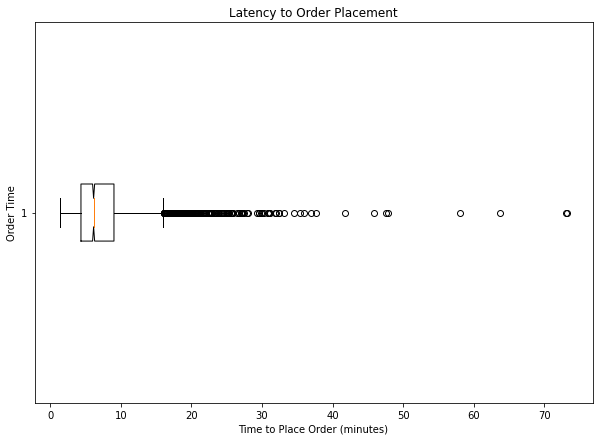

In [12]:
#Create boxplot of time to order 
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

bp = ax.boxplot(order_length_df["how_long_it_took_to_order"], notch=True, vert=False)
ax.set_xlabel("Time to Place Order (minutes)")
ax.set_ylabel("Order Time")
plt.title("Latency to Order Placement")

In [13]:
#boxplot of prep time, transit time, and total time
prep_time_df = new_df[new_df["prep_time"].notna()]
transit_time_df = new_df[new_df["transit_time"].notna()]
total_order_df = new_df[new_df["total_order_time"].notna()]

Text(0.5, 1.0, 'Prep Time, Transit Time, and Total Order Time in Minutes')

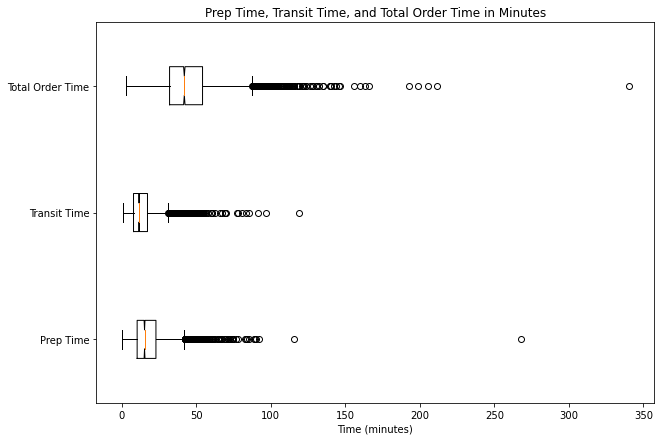

In [14]:
#Create boxplot of prep time, transit time, and total time
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

bp = ax.boxplot([prep_time_df["prep_time"], transit_time_df["transit_time"], total_order_df["total_order_time"]], notch=True, vert=False)
ax.set_yticklabels(["Prep Time", "Transit Time", "Total Order Time"])
ax.set_xlabel("Time (minutes)")
plt.title("Prep Time, Transit Time, and Total Order Time in Minutes")   

In [15]:
#Determine the type of vehicle used for delivery 
vehicle_type = {
    "Type" : ["Bicycle", "Car", "Truck", "Scooter", "Walker", "Van", "Motorcycle"],
    "Count" : [new_df[new_df["vehicle_type"] == "bicycle"].shape[0], new_df[new_df["vehicle_type"] == "car"].shape[0], new_df[new_df["vehicle_type"] == "truck"].shape[0], new_df[new_df["vehicle_type"] == "scooter"].shape[0], new_df[new_df["vehicle_type"] == "walker"].shape[0], new_df[new_df["vehicle_type"] == "van"].shape[0], new_df[new_df["vehicle_type"] == "motorcycle"].shape[0]]
}

Text(0.5, 1.0, 'Delivery Vehicle Types')

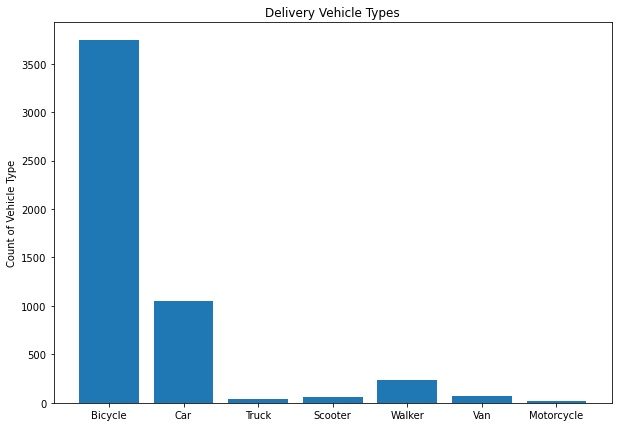

In [16]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

bar = ax.bar(x=vehicle_type["Type"], height=vehicle_type["Count"])
ax.set_ylabel("Count of Vehicle Type")
plt.title("Delivery Vehicle Types")

In [10]:
#Determine distance traveled between pickup and dropoff, this returns distance traveled in miles
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)*0.62137

In [11]:
#compute distance traveled in miles using haversine distance formula, round to 4 decimal places 
new_df["distance_miles"] = round(haversine_distance(new_df["pickup_lat"], new_df["pickup_lon"], new_df["dropoff_lat"], new_df["dropoff_lon"]),4)

In [12]:
#Retrieve distance traveled by each vehicle type 
bicycle = new_df.loc[new_df["vehicle_type"] == "bicycle"]
bicycle_distance = bicycle["distance_miles"].tolist()
car = new_df.loc[new_df["vehicle_type"] == "car"]
car_distance = car["distance_miles"].tolist()
truck = new_df.loc[new_df["vehicle_type"] == 'truck']
truck_distance = truck["distance_miles"].tolist()
scooter = new_df.loc[new_df["vehicle_type"] == 'scooter']
scooter_distance = scooter["distance_miles"].tolist()
walker = new_df.loc[new_df['vehicle_type'] == "walker"]
walker_distance = walker["distance_miles"].tolist()
van = new_df.loc[new_df["vehicle_type"] == 'van']
van_distance = van["distance_miles"].tolist()
motorcycle = new_df.loc[new_df["vehicle_type"]=='motorcycle']
motorcycle_distance = motorcycle["distance_miles"].tolist()
data = [bicycle_distance, car_distance, truck_distance, scooter_distance, walker_distance, van_distance, motorcycle_distance]

Text(0.5, 1.0, 'Distance Travelled by Vehicle Type')

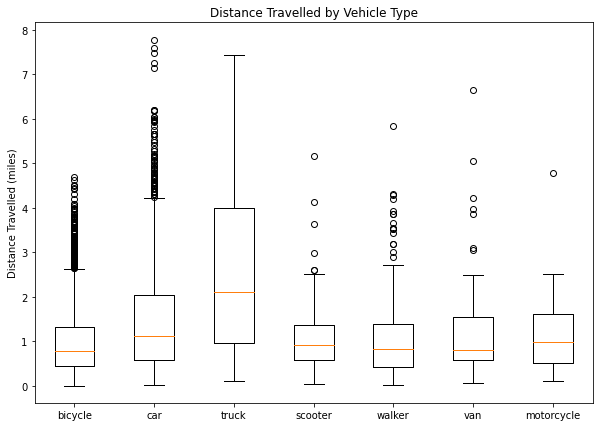

In [14]:
#boxplot of distance travelled by vehicle type 
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

bp = ax.boxplot(data)
ax.set_ylabel("Distance Travelled (miles)")
ax.set_xticklabels(["bicycle", "car", "truck", "scooter", "walker", "van", "motorcycle"])
plt.title("Distance Travelled by Vehicle Type")


In [21]:
#Find top ten pickup restaurants 
top_ten = pd.DataFrame(new_df["pickup_place"].value_counts().head(10))
top_ten_names = top_ten.index.tolist()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

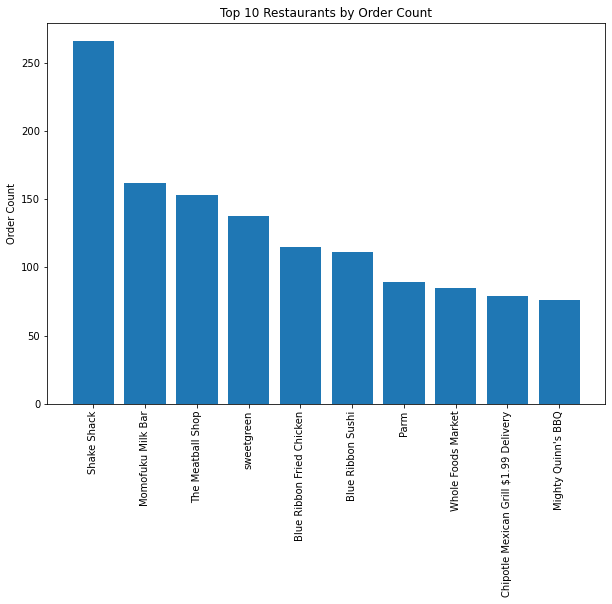

In [22]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

bar = ax.bar(x=top_ten_names, height=top_ten["pickup_place"])
ax.set_ylabel("Order Count")
plt.title("Top 10 Restaurants by Order Count")
plt.xticks(rotation=90)

In [23]:
avg_dropoff_latency_dict = {
    "Name" : top_ten_names
}
avg_dropoff_latency = []

In [24]:
for name in top_ten_names:
    temp = new_df.loc[new_df["pickup_place"] == name]["total_order_time"].mean()
    avg_dropoff_latency.append(temp)
avg_dropoff_latency_dict["time"] = avg_dropoff_latency

Text(0.5, 1.0, 'Fulfillment Time for Top Ten Restaurants')

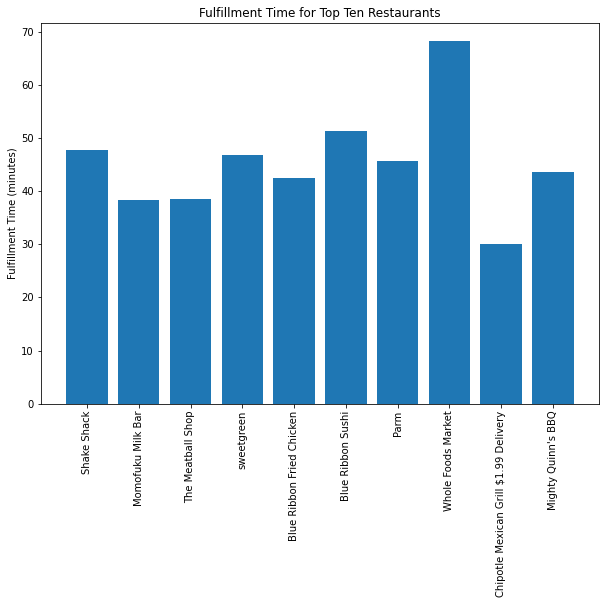

In [25]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

brp = ax.bar(x=avg_dropoff_latency_dict["Name"], height=avg_dropoff_latency_dict["time"])
plt.xticks(rotation=90)
plt.ylabel("Fulfillment Time (minutes)")
plt.title("Fulfillment Time for Top Ten Restaurants")

In [26]:
#Order volumes based on time 
new_df["day"] = new_df["when_the_delivery_started"].dt.day
new_df["hour"] = new_df["when_the_delivery_started"].dt.hour
new_df["weekdate"] = new_df["when_the_delivery_started"].dt.dayofweek
new_df["week"] = new_df["when_the_delivery_started"].dt.week

In [43]:
#Delivery counts by hour 
hhcounts = new_df.groupby(['day', 'hour'])['delivery_id'].count().groupby('hour').sum().tolist()

In [44]:
print(hhcounts)

[64, 31, 22, 7, 5, 2, 19, 27, 84, 149, 287, 367, 282, 238, 231, 251, 376, 644, 795, 626, 396, 192, 119]


In [45]:
hhcounts.append(0)

In [46]:
x = [i for i in range(24)]

Text(0, 0.5, 'Count of Orders')

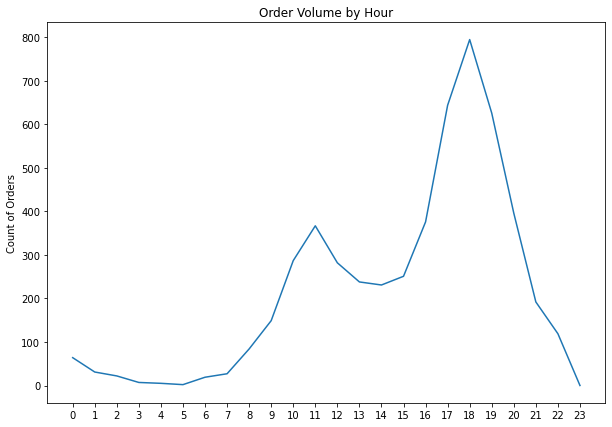

In [50]:
fig = plt.figure(figsize=(10,7))
plt.plot(x, hhcounts)
plt.xticks(range(24))
plt.title("Order Volume by Hour")
plt.ylabel("Count of Orders")

In [456]:
x = [1, 2]
y = [1, 2]

In [200]:
nyc_coords = (40.7128, -74.0060)

In [202]:
gmaps.configure(api_key=api_key)

In [211]:
#Create heatmap of lat/long for pickups on map of NYC using leaflet.js, use counts of distinct lat and long in order to obtain intensity of different heatmap layers
gmaps.configure(api_key=api_key)
fig = gmaps.figure(center=nyc_coords, zoom_level=11)
fig.add_layer(gmaps.heatmap_layer(time_df[["pickup_lat", "pickup_lon"]]))
fig

Figure(layout=FigureLayout(height='420px'))

In [212]:
fig = gmaps.figure(center=nyc_coords, zoom_level=11)
fig.add_layer(gmaps.heatmap_layer(time_df[["dropoff_lat", "dropoff_lon"]]))
fig

Figure(layout=FigureLayout(height='420px'))